# VAE for MNIST clustering and generation

The goal of this notebook is to explore some recent works dealing with variational auto-encoder (VAE).

We will use MNIST dataset and a basic VAE architecture. 

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size)) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            #z = torch.randn(8*n_classes, z_dim).to(device)
            z = torch.randn(8, z_dim)
            z = z.repeat(n_classes,1).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
torch.cuda.is_available()

False

In [4]:
data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

In [5]:
dataset[0][0].size()

torch.Size([1, 28, 28])

# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$.
  
The variational posterior $q_{\phi}(z|x)$ is also called the **encoder** and the generative model $p_{\theta}(x|z)$, the **decoder** or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$ the term $\log p_\theta(x|z)$ reduces to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by [Kingma and Welling (2013)](https://arxiv.org/abs/1312.6114), see also [(Doersch, 2016)](https://arxiv.org/abs/1606.05908) for a tutorial.

There are various examples of VAE in PyTorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

![A variational autoencoder.](vae.png)

In [6]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return torch.sigmoid(self.fc5(F.relu(self.fc4(z))))
    
    def forward(self, x):
        mu, log_var = self.encode(x) 
        x_reconst = self.decode(self.reparameterize(mu, log_var))
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy. The code below is still from the PyTorch tutorial (with minor modifications to avoid warnings!).

In [7]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 284.0960, KL Div: 30.3696
Epoch[1/15], Step [20/469], Reconst Loss: 227.6900, KL Div: 8.3535
Epoch[1/15], Step [30/469], Reconst Loss: 216.9523, KL Div: 9.2478
Epoch[1/15], Step [40/469], Reconst Loss: 204.6467, KL Div: 5.9168
Epoch[1/15], Step [50/469], Reconst Loss: 207.6279, KL Div: 5.9458
Epoch[1/15], Step [60/469], Reconst Loss: 199.7260, KL Div: 6.1618
Epoch[1/15], Step [70/469], Reconst Loss: 200.1361, KL Div: 7.7291
Epoch[1/15], Step [80/469], Reconst Loss: 189.0207, KL Div: 9.1899
Epoch[1/15], Step [90/469], Reconst Loss: 171.3089, KL Div: 11.4305
Epoch[1/15], Step [100/469], Reconst Loss: 162.9391, KL Div: 11.9664
Epoch[1/15], Step [110/469], Reconst Loss: 159.9337, KL Div: 12.5100
Epoch[1/15], Step [120/469], Reconst Loss: 160.7239, KL Div: 11.9407
Epoch[1/15], Step [130/469], Reconst Loss: 152.6797, KL Div: 14.1544
Epoch[1/15], Step [140/469], Reconst Loss: 153.9025, KL Div: 13.2084
Epoch[1/15], Step [150/469], Reconst Loss: 145.055

Epoch[3/15], Step [310/469], Reconst Loss: 90.6035, KL Div: 23.6987
Epoch[3/15], Step [320/469], Reconst Loss: 90.2720, KL Div: 23.6384
Epoch[3/15], Step [330/469], Reconst Loss: 91.5098, KL Div: 24.4248
Epoch[3/15], Step [340/469], Reconst Loss: 89.5014, KL Div: 23.4567
Epoch[3/15], Step [350/469], Reconst Loss: 91.8117, KL Div: 24.6213
Epoch[3/15], Step [360/469], Reconst Loss: 91.4928, KL Div: 24.8028
Epoch[3/15], Step [370/469], Reconst Loss: 86.8482, KL Div: 23.4728
Epoch[3/15], Step [380/469], Reconst Loss: 86.7162, KL Div: 24.4414
Epoch[3/15], Step [390/469], Reconst Loss: 92.1157, KL Div: 24.1949
Epoch[3/15], Step [400/469], Reconst Loss: 88.6502, KL Div: 25.3000
Epoch[3/15], Step [410/469], Reconst Loss: 88.3629, KL Div: 24.1828
Epoch[3/15], Step [420/469], Reconst Loss: 92.1770, KL Div: 23.7727
Epoch[3/15], Step [430/469], Reconst Loss: 87.1083, KL Div: 24.1622
Epoch[3/15], Step [440/469], Reconst Loss: 91.1112, KL Div: 24.5007
Epoch[3/15], Step [450/469], Reconst Loss: 91.58

Epoch[6/15], Step [150/469], Reconst Loss: 82.1006, KL Div: 24.5046
Epoch[6/15], Step [160/469], Reconst Loss: 80.9747, KL Div: 24.4621
Epoch[6/15], Step [170/469], Reconst Loss: 82.9250, KL Div: 25.0573
Epoch[6/15], Step [180/469], Reconst Loss: 83.2785, KL Div: 24.5115
Epoch[6/15], Step [190/469], Reconst Loss: 85.7401, KL Div: 25.0804
Epoch[6/15], Step [200/469], Reconst Loss: 85.9995, KL Div: 25.0063
Epoch[6/15], Step [210/469], Reconst Loss: 83.3934, KL Div: 25.1530
Epoch[6/15], Step [220/469], Reconst Loss: 84.7059, KL Div: 24.2695
Epoch[6/15], Step [230/469], Reconst Loss: 81.1838, KL Div: 24.8536
Epoch[6/15], Step [240/469], Reconst Loss: 83.3824, KL Div: 24.7313
Epoch[6/15], Step [250/469], Reconst Loss: 81.6637, KL Div: 24.5731
Epoch[6/15], Step [260/469], Reconst Loss: 81.7523, KL Div: 24.4800
Epoch[6/15], Step [270/469], Reconst Loss: 86.2204, KL Div: 24.3999
Epoch[6/15], Step [280/469], Reconst Loss: 83.1201, KL Div: 24.9422
Epoch[6/15], Step [290/469], Reconst Loss: 82.57

Epoch[8/15], Step [450/469], Reconst Loss: 82.3710, KL Div: 25.5092
Epoch[8/15], Step [460/469], Reconst Loss: 79.1678, KL Div: 24.6921
Epoch[9/15], Step [10/469], Reconst Loss: 83.5283, KL Div: 25.6838
Epoch[9/15], Step [20/469], Reconst Loss: 82.2808, KL Div: 25.7373
Epoch[9/15], Step [30/469], Reconst Loss: 83.3725, KL Div: 24.5614
Epoch[9/15], Step [40/469], Reconst Loss: 83.2683, KL Div: 26.1367
Epoch[9/15], Step [50/469], Reconst Loss: 81.2180, KL Div: 25.4631
Epoch[9/15], Step [60/469], Reconst Loss: 83.1636, KL Div: 24.8288
Epoch[9/15], Step [70/469], Reconst Loss: 78.5296, KL Div: 25.2824
Epoch[9/15], Step [80/469], Reconst Loss: 82.3919, KL Div: 25.4818
Epoch[9/15], Step [90/469], Reconst Loss: 80.9150, KL Div: 24.4143
Epoch[9/15], Step [100/469], Reconst Loss: 83.6417, KL Div: 24.7210
Epoch[9/15], Step [110/469], Reconst Loss: 79.6796, KL Div: 24.6358
Epoch[9/15], Step [120/469], Reconst Loss: 77.3805, KL Div: 24.8861
Epoch[9/15], Step [130/469], Reconst Loss: 80.5508, KL Di

Epoch[11/15], Step [270/469], Reconst Loss: 77.2751, KL Div: 24.1211
Epoch[11/15], Step [280/469], Reconst Loss: 81.0320, KL Div: 24.6175
Epoch[11/15], Step [290/469], Reconst Loss: 78.9790, KL Div: 25.9855
Epoch[11/15], Step [300/469], Reconst Loss: 81.8854, KL Div: 25.6924
Epoch[11/15], Step [310/469], Reconst Loss: 79.6943, KL Div: 25.2487
Epoch[11/15], Step [320/469], Reconst Loss: 86.0759, KL Div: 26.5000
Epoch[11/15], Step [330/469], Reconst Loss: 79.9281, KL Div: 25.0572
Epoch[11/15], Step [340/469], Reconst Loss: 80.6222, KL Div: 25.5163
Epoch[11/15], Step [350/469], Reconst Loss: 82.0786, KL Div: 25.0335
Epoch[11/15], Step [360/469], Reconst Loss: 78.6853, KL Div: 25.1542
Epoch[11/15], Step [370/469], Reconst Loss: 77.8398, KL Div: 24.7747
Epoch[11/15], Step [380/469], Reconst Loss: 78.0306, KL Div: 25.3367
Epoch[11/15], Step [390/469], Reconst Loss: 79.0572, KL Div: 25.0981
Epoch[11/15], Step [400/469], Reconst Loss: 78.3656, KL Div: 24.7195
Epoch[11/15], Step [410/469], Reco

Epoch[14/15], Step [90/469], Reconst Loss: 82.0593, KL Div: 25.8734
Epoch[14/15], Step [100/469], Reconst Loss: 78.5665, KL Div: 24.8236
Epoch[14/15], Step [110/469], Reconst Loss: 81.7858, KL Div: 26.4462
Epoch[14/15], Step [120/469], Reconst Loss: 80.6277, KL Div: 25.5628
Epoch[14/15], Step [130/469], Reconst Loss: 78.3207, KL Div: 24.9539
Epoch[14/15], Step [140/469], Reconst Loss: 78.2290, KL Div: 25.6992
Epoch[14/15], Step [150/469], Reconst Loss: 78.8121, KL Div: 25.3637
Epoch[14/15], Step [160/469], Reconst Loss: 79.2786, KL Div: 25.8852
Epoch[14/15], Step [170/469], Reconst Loss: 78.3853, KL Div: 25.4487
Epoch[14/15], Step [180/469], Reconst Loss: 79.6814, KL Div: 25.6496
Epoch[14/15], Step [190/469], Reconst Loss: 80.5416, KL Div: 25.1291
Epoch[14/15], Step [200/469], Reconst Loss: 78.5566, KL Div: 24.7250
Epoch[14/15], Step [210/469], Reconst Loss: 80.5605, KL Div: 26.0650
Epoch[14/15], Step [220/469], Reconst Loss: 78.2887, KL Div: 25.2904
Epoch[14/15], Step [230/469], Recon

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

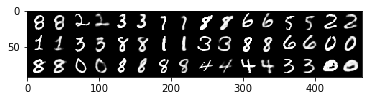

In [8]:
plot_reconstruction(model)

Let's see now how our network generates new samples.

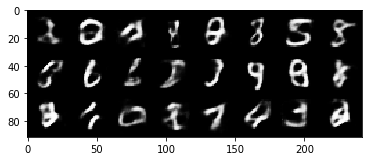

In [9]:
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this notebook, we explore ways to generates zeroes, ones, twos and so on. 


As a by-product, we show how our VAE will allow us to do clustering tahnsk to the Gumbel VAE described below. But before that, we start by cheatin a little bit...

# Cheating with the 'conditional' VAE

We will first use the labels here (like what we did in the course with [Conditional GAN](https://dataflowr.github.io/website/modules/10-generative-adversarial-networks/)). The idea is to modify slightly the architecture above by feeding a onehot version of the label to the decoder in addition to the code computed by the decoder. 

First code a function transforming a label in its onehot encoding. This function will be used in the training loop (not in the architecture of the neural network!).

In [10]:
n_classes = 10

# take labels (from the dataloader) and return labels onehot-encoded

def l_2_onehot(labels,nb_digits=n_classes):
    
    labels = labels.unsqueeze(1)
    labels_onehot = torch.FloatTensor(labels.size()[0], nb_digits).to(device)
    labels_onehot.zero_()
    labels_onehot.scatter_(1, labels, 1)
    
    return labels_onehot
    

You can test it on a batch.

In [11]:
(x,labels) = next(iter(data_loader))

In [12]:
labels

tensor([1, 6, 3, 7, 2, 4, 1, 7, 1, 8, 1, 1, 1, 4, 2, 7, 5, 6, 3, 0, 8, 6, 1, 2,
        1, 1, 9, 9, 4, 4, 5, 7, 4, 9, 7, 4, 6, 9, 5, 3, 3, 8, 2, 4, 3, 6, 3, 1,
        6, 2, 5, 3, 2, 2, 5, 2, 8, 7, 4, 7, 2, 0, 2, 1, 9, 5, 6, 8, 6, 3, 2, 7,
        8, 0, 4, 9, 4, 3, 5, 1, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 9, 2, 8, 0,
        7, 2, 7, 1, 9, 9, 7, 6, 0, 6, 3, 1, 9, 4, 7, 9, 1, 3, 9, 5, 2, 0, 9, 5,
        9, 4, 6, 3, 6, 8, 2, 4])

In [13]:
l_2_onehot(labels)

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Now modifiy the architecture of the VAE where the decoder takes as input the random code concatenated with the onehot encoding of the label.

In [14]:
n_classes = 10

class VAE_Cond(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Cond, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim + n_classes, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x), self.fc3(x)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, l_onehot):
        concat = torch.cat((z,l_onehot),1)
        x = F.relu(self.fc4(concat))
        return torch.sigmoid(self.fc5(x))     
    
    def forward(self, x, l_onehot):
        mu, log_var = self.encode(x)
        x_reconst = self.decode(self.reparameterize(mu, log_var),l_onehot)
        return x_reconst, mu, log_var

Test your new model on a batch:

In [15]:
model_C = VAE_Cond().to(device)
x = x.to(device).view(-1, image_size)
l_onehot = l_2_onehot(labels)
l_onehot = l_onehot.to(device)
model_C(x, l_onehot)

(tensor([[0.5792, 0.5219, 0.5335,  ..., 0.4630, 0.5286, 0.4057],
         [0.5032, 0.5344, 0.4661,  ..., 0.4802, 0.4546, 0.4753],
         [0.4735, 0.4641, 0.4673,  ..., 0.4440, 0.5102, 0.4232],
         ...,
         [0.5650, 0.5668, 0.5301,  ..., 0.4434, 0.4403, 0.4780],
         [0.4550, 0.6058, 0.4451,  ..., 0.5234, 0.4619, 0.4375],
         [0.4867, 0.5622, 0.4755,  ..., 0.3963, 0.4481, 0.4874]],
        grad_fn=<SigmoidBackward0>),
 tensor([[ 0.0519, -0.0696, -0.0611,  ..., -0.0482,  0.0124,  0.0145],
         [-0.0549, -0.1898, -0.1133,  ..., -0.0347,  0.0816,  0.0247],
         [ 0.0093, -0.0554, -0.0677,  ..., -0.0578,  0.0593,  0.0780],
         ...,
         [ 0.0317,  0.0152, -0.0914,  ..., -0.0149, -0.0082, -0.0097],
         [ 0.0980, -0.2202,  0.0770,  ..., -0.0391, -0.0007, -0.0557],
         [ 0.0786, -0.0679, -0.0936,  ..., -0.1292, -0.0075, -0.0320]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.0280, -0.1609, -0.1069,  ..., -0.0473,  0.0461,  0.0048],
         [ 

Now you can modify the training loop of your network. The parameter $\beta$ will allow you to scale the KL term in your loss as explained in the [$\beta$-VAE paper](https://openreview.net/forum?id=Sy2fzU9gl) see formula (4) in the paper.

In [16]:
def train_C(model, data_loader=data_loader,num_epochs=num_epochs, beta=10., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            #
            # your code here
            #
            l_onehot = l_2_onehot(labels)
            x_reconst, mu, log_var = model(x, l_onehot)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div =  - 0.5 * torch.sum(1 - mu.pow(2) - log_var.exp() + log_var)
            
            # Backprop and optimize
            loss = reconst_loss + beta*kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x),
                                   kl_div.item()/len(x)))

In [17]:
model_C = VAE_Cond().to(device)
optimizer = torch.optim.Adam(model_C.parameters(), lr=learning_rate)

In [18]:
train_C(model_C,num_epochs=15,verbose=True)

Epoch[1/15], Step [10/469], Reconst Loss: 351.0739, KL Div: 1.8003
Epoch[1/15], Step [20/469], Reconst Loss: 255.3937, KL Div: 1.3392
Epoch[1/15], Step [30/469], Reconst Loss: 226.3247, KL Div: 0.6558
Epoch[1/15], Step [40/469], Reconst Loss: 223.4113, KL Div: 0.3767
Epoch[1/15], Step [50/469], Reconst Loss: 210.8641, KL Div: 0.2982
Epoch[1/15], Step [60/469], Reconst Loss: 203.7855, KL Div: 0.2601
Epoch[1/15], Step [70/469], Reconst Loss: 202.3323, KL Div: 0.2244
Epoch[1/15], Step [80/469], Reconst Loss: 194.9387, KL Div: 0.2835
Epoch[1/15], Step [90/469], Reconst Loss: 198.4004, KL Div: 0.3241
Epoch[1/15], Step [100/469], Reconst Loss: 200.0779, KL Div: 0.2501
Epoch[1/15], Step [110/469], Reconst Loss: 192.3642, KL Div: 0.3437
Epoch[1/15], Step [120/469], Reconst Loss: 198.6936, KL Div: 0.3147
Epoch[1/15], Step [130/469], Reconst Loss: 190.9317, KL Div: 0.3325
Epoch[1/15], Step [140/469], Reconst Loss: 192.4890, KL Div: 0.3787
Epoch[1/15], Step [150/469], Reconst Loss: 194.7395, KL D

Epoch[3/15], Step [310/469], Reconst Loss: 151.5261, KL Div: 1.0074
Epoch[3/15], Step [320/469], Reconst Loss: 151.0136, KL Div: 1.1672
Epoch[3/15], Step [330/469], Reconst Loss: 155.0441, KL Div: 1.0950
Epoch[3/15], Step [340/469], Reconst Loss: 154.6130, KL Div: 1.1552
Epoch[3/15], Step [350/469], Reconst Loss: 157.8485, KL Div: 1.1611
Epoch[3/15], Step [360/469], Reconst Loss: 154.5387, KL Div: 1.1301
Epoch[3/15], Step [370/469], Reconst Loss: 153.6625, KL Div: 1.1043
Epoch[3/15], Step [380/469], Reconst Loss: 156.3104, KL Div: 1.0750
Epoch[3/15], Step [390/469], Reconst Loss: 154.4436, KL Div: 1.2223
Epoch[3/15], Step [400/469], Reconst Loss: 151.5413, KL Div: 1.1859
Epoch[3/15], Step [410/469], Reconst Loss: 150.7273, KL Div: 1.1703
Epoch[3/15], Step [420/469], Reconst Loss: 151.5574, KL Div: 1.1763
Epoch[3/15], Step [430/469], Reconst Loss: 156.6510, KL Div: 1.1275
Epoch[3/15], Step [440/469], Reconst Loss: 150.5106, KL Div: 1.2274
Epoch[3/15], Step [450/469], Reconst Loss: 156.4

Epoch[6/15], Step [150/469], Reconst Loss: 145.5368, KL Div: 1.3636
Epoch[6/15], Step [160/469], Reconst Loss: 146.1103, KL Div: 1.3508
Epoch[6/15], Step [170/469], Reconst Loss: 148.9745, KL Div: 1.4238
Epoch[6/15], Step [180/469], Reconst Loss: 147.2577, KL Div: 1.4166
Epoch[6/15], Step [190/469], Reconst Loss: 146.5769, KL Div: 1.4327
Epoch[6/15], Step [200/469], Reconst Loss: 151.4207, KL Div: 1.4301
Epoch[6/15], Step [210/469], Reconst Loss: 151.8093, KL Div: 1.3348
Epoch[6/15], Step [220/469], Reconst Loss: 146.1490, KL Div: 1.4379
Epoch[6/15], Step [230/469], Reconst Loss: 147.1545, KL Div: 1.4963
Epoch[6/15], Step [240/469], Reconst Loss: 151.0900, KL Div: 1.5006
Epoch[6/15], Step [250/469], Reconst Loss: 144.4253, KL Div: 1.3526
Epoch[6/15], Step [260/469], Reconst Loss: 145.3765, KL Div: 1.4446
Epoch[6/15], Step [270/469], Reconst Loss: 137.1834, KL Div: 1.4117
Epoch[6/15], Step [280/469], Reconst Loss: 141.8014, KL Div: 1.4077
Epoch[6/15], Step [290/469], Reconst Loss: 150.3

Epoch[8/15], Step [450/469], Reconst Loss: 134.9729, KL Div: 1.4595
Epoch[8/15], Step [460/469], Reconst Loss: 146.4272, KL Div: 1.3647
Epoch[9/15], Step [10/469], Reconst Loss: 147.7613, KL Div: 1.5214
Epoch[9/15], Step [20/469], Reconst Loss: 145.7143, KL Div: 1.5118
Epoch[9/15], Step [30/469], Reconst Loss: 144.5338, KL Div: 1.5499
Epoch[9/15], Step [40/469], Reconst Loss: 151.8375, KL Div: 1.6692
Epoch[9/15], Step [50/469], Reconst Loss: 136.7456, KL Div: 1.3902
Epoch[9/15], Step [60/469], Reconst Loss: 145.6887, KL Div: 1.5622
Epoch[9/15], Step [70/469], Reconst Loss: 149.9197, KL Div: 1.4191
Epoch[9/15], Step [80/469], Reconst Loss: 143.2676, KL Div: 1.4442
Epoch[9/15], Step [90/469], Reconst Loss: 143.7588, KL Div: 1.5446
Epoch[9/15], Step [100/469], Reconst Loss: 144.7806, KL Div: 1.5273
Epoch[9/15], Step [110/469], Reconst Loss: 144.7145, KL Div: 1.4852
Epoch[9/15], Step [120/469], Reconst Loss: 140.9142, KL Div: 1.4950
Epoch[9/15], Step [130/469], Reconst Loss: 150.2285, KL D

Epoch[11/15], Step [270/469], Reconst Loss: 147.9401, KL Div: 1.6219
Epoch[11/15], Step [280/469], Reconst Loss: 148.3009, KL Div: 1.5364
Epoch[11/15], Step [290/469], Reconst Loss: 145.0523, KL Div: 1.5878
Epoch[11/15], Step [300/469], Reconst Loss: 150.6592, KL Div: 1.6026
Epoch[11/15], Step [310/469], Reconst Loss: 143.9720, KL Div: 1.6254
Epoch[11/15], Step [320/469], Reconst Loss: 145.3199, KL Div: 1.6428
Epoch[11/15], Step [330/469], Reconst Loss: 142.6302, KL Div: 1.5658
Epoch[11/15], Step [340/469], Reconst Loss: 143.9118, KL Div: 1.6095
Epoch[11/15], Step [350/469], Reconst Loss: 148.2343, KL Div: 1.6200
Epoch[11/15], Step [360/469], Reconst Loss: 138.8929, KL Div: 1.6478
Epoch[11/15], Step [370/469], Reconst Loss: 135.5860, KL Div: 1.5852
Epoch[11/15], Step [380/469], Reconst Loss: 146.5474, KL Div: 1.5305
Epoch[11/15], Step [390/469], Reconst Loss: 146.9012, KL Div: 1.6409
Epoch[11/15], Step [400/469], Reconst Loss: 145.3852, KL Div: 1.5386
Epoch[11/15], Step [410/469], Reco

Epoch[14/15], Step [90/469], Reconst Loss: 144.5378, KL Div: 1.7797
Epoch[14/15], Step [100/469], Reconst Loss: 134.9467, KL Div: 1.5227
Epoch[14/15], Step [110/469], Reconst Loss: 137.4131, KL Div: 1.6566
Epoch[14/15], Step [120/469], Reconst Loss: 144.5406, KL Div: 1.5933
Epoch[14/15], Step [130/469], Reconst Loss: 140.5640, KL Div: 1.6561
Epoch[14/15], Step [140/469], Reconst Loss: 147.1889, KL Div: 1.5916
Epoch[14/15], Step [150/469], Reconst Loss: 148.6770, KL Div: 1.6174
Epoch[14/15], Step [160/469], Reconst Loss: 138.8918, KL Div: 1.6373
Epoch[14/15], Step [170/469], Reconst Loss: 146.4600, KL Div: 1.7607
Epoch[14/15], Step [180/469], Reconst Loss: 137.3997, KL Div: 1.6798
Epoch[14/15], Step [190/469], Reconst Loss: 132.6725, KL Div: 1.6531
Epoch[14/15], Step [200/469], Reconst Loss: 140.7621, KL Div: 1.8309
Epoch[14/15], Step [210/469], Reconst Loss: 139.6202, KL Div: 1.7670
Epoch[14/15], Step [220/469], Reconst Loss: 141.4554, KL Div: 1.5930
Epoch[14/15], Step [230/469], Recon

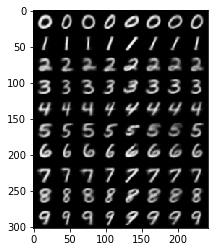

In [19]:
plot_conditional_generation(model_C, n=8)

Here you should get nice results. Now we will avoid the use of the labels...

# No cheating with Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NeurIPS paper: [(Dupont, 2018)](https://arxiv.org/abs/1804.00104). Make minimal modifications to previous architecture.

The idea is to incorporate a categorical variable in your latent space. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction. Moreover, if things work as planned, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

As noticed above, in order to sample random variables while still being able to use backpropagation, we need to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in [(Jang et al., 2016)](https://arxiv.org/abs/1611.01144). This is implemented in PyTorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/nn.html?highlight=gumbel_softmax#torch.nn.functional.gumbel_softmax).

In [20]:
n_classes = 10

class VAE_Gumbel(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Gumbel, self).__init__()
        #
        # your code here
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.classifier = nn.Linear(h_dim, n_classes)
        self.fc4 = nn.Linear(z_dim + n_classes, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x), self.fc3(x), F.log_softmax(self.classifier(x), dim=-1)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        concat = torch.cat((z,y_onehot),1)
        h = F.relu(self.fc4(concat))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var, classif = self.encode(x)
        z = self.reparameterize(mu, log_var)
        y_onehot = F.gumbel_softmax(classif)
        x_reconst = self.decode(z,y_onehot)
        return x_reconst, mu, log_var, classif

In [21]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in [(Dupont, 2018)](https://arxiv.org/abs/1804.00104)

In [22]:
def train_G(model, data_loader=data_loader,num_epochs=num_epochs, beta = 1., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            
            # your code here
            l_onehot = l_2_onehot(labels)
            x_reconst, mu, log_var, classif = model(x)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            
            # your code here
            kl_div =  (- 0.5) * torch.sum(1 - mu.pow(2) - log_var.exp() + log_var) 
            H_cat = torch.sum(classif * torch.exp(classif)) + torch.log(torch.FloatTensor([classif.shape[1]]))*classif.shape[0]
            index_max = torch.argmax(classif,dim=1)
            
            nmi = normalized_mutual_info_score(index_max, labels.cpu().detach().numpy())
            nmi_scores.append(nmi)
            
            # Backprop and optimize
            loss = reconst_loss + beta*kl_div + beta*H_cat # your code here
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x),
                                   kl_div.item()/len(x), H_cat.item()/len(x)))
    return nmi_scores

In [23]:
nmi_scores = train_G(model_G,num_epochs=10,verbose=True)

Epoch[1/10], Step [10/469], Reconst Loss: 283.0761, KL Div: 36.5363, Entropy: 0.3661
Epoch[1/10], Step [20/469], Reconst Loss: 236.6965, KL Div: 9.8561, Entropy: 0.0322
Epoch[1/10], Step [30/469], Reconst Loss: 216.0926, KL Div: 9.0759, Entropy: 0.0096
Epoch[1/10], Step [40/469], Reconst Loss: 200.9935, KL Div: 7.3885, Entropy: 0.0104
Epoch[1/10], Step [50/469], Reconst Loss: 203.7133, KL Div: 5.6441, Entropy: 0.0117
Epoch[1/10], Step [60/469], Reconst Loss: 194.3227, KL Div: 7.1001, Entropy: 0.0182
Epoch[1/10], Step [70/469], Reconst Loss: 194.1481, KL Div: 7.0328, Entropy: 0.0183
Epoch[1/10], Step [80/469], Reconst Loss: 179.9979, KL Div: 8.5961, Entropy: 0.0156
Epoch[1/10], Step [90/469], Reconst Loss: 180.0094, KL Div: 9.6521, Entropy: 0.0198
Epoch[1/10], Step [100/469], Reconst Loss: 179.7856, KL Div: 9.7649, Entropy: 0.0247
Epoch[1/10], Step [110/469], Reconst Loss: 170.4114, KL Div: 11.4111, Entropy: 0.0230
Epoch[1/10], Step [120/469], Reconst Loss: 161.5799, KL Div: 11.3429, En

Epoch[3/10], Step [50/469], Reconst Loss: 101.9201, KL Div: 22.6326, Entropy: 0.0234
Epoch[3/10], Step [60/469], Reconst Loss: 94.2751, KL Div: 23.8948, Entropy: 0.0254
Epoch[3/10], Step [70/469], Reconst Loss: 90.8941, KL Div: 23.9452, Entropy: 0.0255
Epoch[3/10], Step [80/469], Reconst Loss: 90.6127, KL Div: 22.8032, Entropy: 0.0224
Epoch[3/10], Step [90/469], Reconst Loss: 94.6957, KL Div: 24.2253, Entropy: 0.0268
Epoch[3/10], Step [100/469], Reconst Loss: 93.0443, KL Div: 22.9067, Entropy: 0.0246
Epoch[3/10], Step [110/469], Reconst Loss: 91.0738, KL Div: 22.9496, Entropy: 0.0274
Epoch[3/10], Step [120/469], Reconst Loss: 89.9885, KL Div: 22.9906, Entropy: 0.0275
Epoch[3/10], Step [130/469], Reconst Loss: 95.1880, KL Div: 23.5044, Entropy: 0.0280
Epoch[3/10], Step [140/469], Reconst Loss: 91.2353, KL Div: 23.4617, Entropy: 0.0263
Epoch[3/10], Step [150/469], Reconst Loss: 94.4238, KL Div: 23.3611, Entropy: 0.0257
Epoch[3/10], Step [160/469], Reconst Loss: 96.0373, KL Div: 23.2126, 

Epoch[5/10], Step [110/469], Reconst Loss: 83.7019, KL Div: 24.1509, Entropy: 0.0558
Epoch[5/10], Step [120/469], Reconst Loss: 89.3545, KL Div: 24.3757, Entropy: 0.0604
Epoch[5/10], Step [130/469], Reconst Loss: 88.2455, KL Div: 24.0978, Entropy: 0.0510
Epoch[5/10], Step [140/469], Reconst Loss: 91.4748, KL Div: 25.1982, Entropy: 0.0546
Epoch[5/10], Step [150/469], Reconst Loss: 83.4825, KL Div: 24.2970, Entropy: 0.0473
Epoch[5/10], Step [160/469], Reconst Loss: 82.6556, KL Div: 24.9933, Entropy: 0.0558
Epoch[5/10], Step [170/469], Reconst Loss: 85.7687, KL Div: 24.8146, Entropy: 0.0496
Epoch[5/10], Step [180/469], Reconst Loss: 83.9764, KL Div: 24.3484, Entropy: 0.0524
Epoch[5/10], Step [190/469], Reconst Loss: 87.9611, KL Div: 23.8302, Entropy: 0.0460
Epoch[5/10], Step [200/469], Reconst Loss: 84.0828, KL Div: 25.1844, Entropy: 0.0550
Epoch[5/10], Step [210/469], Reconst Loss: 88.1629, KL Div: 25.9715, Entropy: 0.0625
Epoch[5/10], Step [220/469], Reconst Loss: 82.6787, KL Div: 23.80

Epoch[7/10], Step [170/469], Reconst Loss: 80.6168, KL Div: 24.8402, Entropy: 0.1910
Epoch[7/10], Step [180/469], Reconst Loss: 82.4073, KL Div: 24.1826, Entropy: 0.1768
Epoch[7/10], Step [190/469], Reconst Loss: 81.0326, KL Div: 25.5016, Entropy: 0.1460
Epoch[7/10], Step [200/469], Reconst Loss: 85.3895, KL Div: 24.8788, Entropy: 0.2084
Epoch[7/10], Step [210/469], Reconst Loss: 84.6431, KL Div: 24.6399, Entropy: 0.1988
Epoch[7/10], Step [220/469], Reconst Loss: 82.9562, KL Div: 24.9284, Entropy: 0.1828
Epoch[7/10], Step [230/469], Reconst Loss: 81.7150, KL Div: 24.3834, Entropy: 0.1822
Epoch[7/10], Step [240/469], Reconst Loss: 85.1875, KL Div: 25.6641, Entropy: 0.2145
Epoch[7/10], Step [250/469], Reconst Loss: 84.1759, KL Div: 24.9335, Entropy: 0.1792
Epoch[7/10], Step [260/469], Reconst Loss: 86.3665, KL Div: 25.3600, Entropy: 0.2163
Epoch[7/10], Step [270/469], Reconst Loss: 83.3472, KL Div: 25.1502, Entropy: 0.1656
Epoch[7/10], Step [280/469], Reconst Loss: 85.8749, KL Div: 25.37

Epoch[9/10], Step [230/469], Reconst Loss: 83.0586, KL Div: 25.5534, Entropy: 0.3449
Epoch[9/10], Step [240/469], Reconst Loss: 80.2169, KL Div: 24.5427, Entropy: 0.3110
Epoch[9/10], Step [250/469], Reconst Loss: 83.7140, KL Div: 25.2276, Entropy: 0.2945
Epoch[9/10], Step [260/469], Reconst Loss: 80.3707, KL Div: 25.0897, Entropy: 0.3256
Epoch[9/10], Step [270/469], Reconst Loss: 81.6445, KL Div: 24.4993, Entropy: 0.3052
Epoch[9/10], Step [280/469], Reconst Loss: 80.4511, KL Div: 24.7570, Entropy: 0.2807
Epoch[9/10], Step [290/469], Reconst Loss: 79.5582, KL Div: 24.8284, Entropy: 0.2715
Epoch[9/10], Step [300/469], Reconst Loss: 77.7398, KL Div: 24.8317, Entropy: 0.3021
Epoch[9/10], Step [310/469], Reconst Loss: 81.8692, KL Div: 24.8848, Entropy: 0.3139
Epoch[9/10], Step [320/469], Reconst Loss: 78.0367, KL Div: 24.4044, Entropy: 0.3155
Epoch[9/10], Step [330/469], Reconst Loss: 84.3883, KL Div: 25.9252, Entropy: 0.3244
Epoch[9/10], Step [340/469], Reconst Loss: 83.8641, KL Div: 23.96

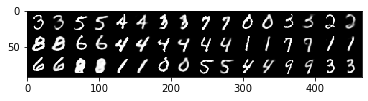

In [24]:
plot_reconstruction(model_G)

This was for reconstruction, but we care more about generation. For each category, we are generating 8 samples thanks to the `plot_conditional_generation()` function.

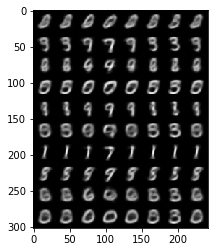

In [50]:
plot_conditional_generation(model_G, n=8)

It does not look like our original idea is working...

What is happening is that our network is not using the categorical variable. We can track the [normalized mutual information](https://en.wikipedia.org/wiki/Mutual_information#Normalized_variants) (see [this method in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)) between the true labels and the labels predicted by our network (just by taking the category with maximal probability). 

Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

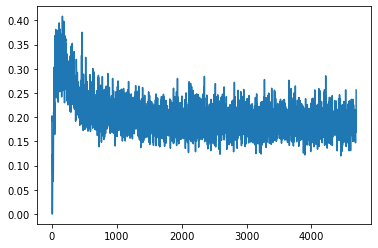

In [26]:
plt.plot(nmi_scores)

This problem is explained in [(Burgess et al., 2018)](https://arxiv.org/abs/1804.03599) and a solution is proposed in Section 5.

In order to force our network to use the categorical variable, we will change the loss according to [(Dupont, 2018)](https://arxiv.org/abs/1804.00104), Section 3 Equation (7).

Implement this change in the training loop and plot the new NMI curve. For $\beta = 20, C_z=100, C_c=100$, you should see that NMI increases.

In [51]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

In [52]:
def train_G_modified_loss(model, data_loader=data_loader,num_epochs=num_epochs, beta=1. , C_z_fin=0, C_c_fin=0, verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            #
            # your code here
            #
            l_onehot = l_2_onehot(labels)
            x_reconst, mu, log_var, classif = model(x)

            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            #
            # your code here
            #

            kl_div =  - 0.5 * torch.sum(1 - mu.pow(2) - log_var.exp() + log_var) 
            H_cat =  torch.sum(classif * torch.exp(classif)) + torch.log(torch.FloatTensor([classif.shape[1]]))*classif.shape[0]
            index_max = torch.argmax(classif,dim=1)

            nmi_score = normalized_mutual_info_score(index_max, labels.cpu().detach().numpy())
            nmi_scores.append(nmi_score)

            # Backprop and optimize
            loss = reconst_loss + beta*torch.abs(beta*torch.abs((H_cat-C_c_fin) + (kl_div - C_z_fin))) # your code here
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 100 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}, NMI Score: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x),
                                   kl_div.item()/len(x), H_cat.item()/len(x), nmi_score))
                    
    return nmi_scores

In [53]:
# Hyper-parameters
num_epochs = 20
learning_rate = 1e-3
beta = 20
C_z_fin=100
C_c_fin=100

model_G = VAE_Gumbel(z_dim = z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

nmi_scores = train_G_modified_loss(model_G, data_loader, num_epochs=num_epochs, beta=beta, C_z_fin=C_z_fin, C_c_fin=C_c_fin)

Epoch[1/20], Step [100/469], Reconst Loss: 212.5179, KL Div: 1.7793, Entropy: 0.0207, NMI Score: 0.1837
Epoch[1/20], Step [200/469], Reconst Loss: 201.6371, KL Div: 1.5822, Entropy: 0.0195, NMI Score: 0.1849
Epoch[1/20], Step [300/469], Reconst Loss: 198.5360, KL Div: 1.6776, Entropy: 0.0185, NMI Score: 0.2675
Epoch[1/20], Step [400/469], Reconst Loss: 197.4660, KL Div: 1.6035, Entropy: 0.0181, NMI Score: 0.2642
Epoch[2/20], Step [100/469], Reconst Loss: 197.9958, KL Div: 1.5199, Entropy: 0.0183, NMI Score: 0.3826
Epoch[2/20], Step [200/469], Reconst Loss: 197.4605, KL Div: 1.5221, Entropy: 0.0168, NMI Score: 0.3514
Epoch[2/20], Step [300/469], Reconst Loss: 184.1696, KL Div: 1.4637, Entropy: 0.0168, NMI Score: 0.3378
Epoch[2/20], Step [400/469], Reconst Loss: 187.1066, KL Div: 1.4768, Entropy: 0.0164, NMI Score: 0.3454
Epoch[3/20], Step [100/469], Reconst Loss: 188.0931, KL Div: 1.7812, Entropy: 0.0220, NMI Score: 0.3295
Epoch[3/20], Step [200/469], Reconst Loss: 188.7319, KL Div: 1.9

Epoch[20/20], Step [400/469], Reconst Loss: 160.9620, KL Div: 0.6077, Entropy: 0.9699, NMI Score: 0.3499


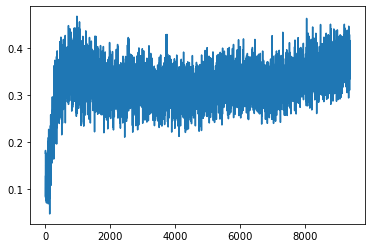

In [54]:
plt.plot(nmi_scores)

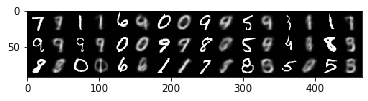

In [55]:
plot_reconstruction(model_G)

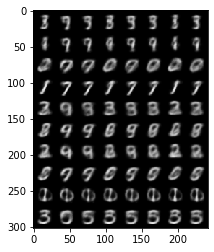

In [56]:
plot_conditional_generation(model_G, fix_number=None)

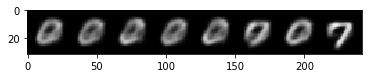

In [57]:
plot_conditional_generation(model_G, fix_number=2)